In [ ]:
#%load_ext cudf.pandas
import pandas as pd
import numpy as np
import os
import pickle
import gzip


# Set random seeds to ensure repeatability
SEED = 2024

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    rng = np.random.default_rng(seed)

    return rng

rng = set_seeds(SEED)

In [ ]:
# read zip file from google drive
from google.colab import drive
drive.mount('/content/drive')#,timeout_ms=300000, force_remount=True, readonly=True)

Mounted at /content/drive


In [ ]:
#first_pass_data_brd4={'Xtr':Xtr,'ytr':ytr,'Xval':Xval,'yval':yval,'Xte':Xte,'yte':yte}

file_path = "/content/drive/My Drive"+os.sep+"Belka_Data"+os.sep

with gzip.open(file_path+"brd4_alone_trainTest.pkl.zip",'rb') as f: #brd4_alone_balanced_trainTest.pkl
  data = pickle.load(f)

In [ ]:
# Import tools for data splits and model development
from sklearn.model_selection import StratifiedKFold

# for computing performance metrics
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.metrics import confusion_matrix as cfmatrix

# compute all performance metrics for evaluation
def getMetrics(ytr,cm,th=0.5):
  tn, fp, fn, tp = cfmatrix(ytr, cm>th).ravel()

  auc = roc_auc_score(ytr,cm)
  ap = average_precision_score(ytr,cm)
  acc = (tp+tn)/(tp+tn+fp+fn)
  sens = tp/(tp+fn)
  spes = tn/(fp+tn)
  ppv = tp/(tp+fp)
  npv = tn/(tn+fn)


  return pd.Series([auc,ap,tp,fp,fn,tn,th,acc,sens,spes,ppv,npv],index=['AUC','AUCPR','TP','FP','FN','TN','Threshold',
                                                                        'Acc','Sensitivity','Specificity','Precision','NPV'])

In [ ]:
mol_feat_names = ['logP', 'MW', 'rotB', 'HBA', 'HBD', 'nRING', 'TPSA']
morgan_feat_names = []
for k in range(1024):
  morgan_feat_names.append('morgan_'+str(k))

In [ ]:
'''

# Training data -- I am combining validation data here because the search will be using CV

# using morgan finger print features that showed better promise for BRD4 classification
Xtm = np.concatenate((data['Xtr'][1],data['Xval'][1]),axis=0)
Xtr = np.concatenate((data['Xtr'][2],data['Xval'][2]),axis=0)
ytr = np.concatenate((data['ytr'],data['yval']))

Xtem = data['Xte'][1]
Xte = data['Xte'][2]
yte = data['yte']

print(Xtr.shape)
'''
# Training data -- using validation data for pure testing

# using morgan finger print features that showed better promise for BRD4 classification


Xtm = data['Xtr'][1]
Xtr = data['Xtr'][2]
ytr =data['ytr']

Xtem = data['Xval'][1]
Xte =data['Xval'][2]
yte = data['yval']

'''
Xtem = data['Xte'][1]
Xte = data['Xte'][2]
yte = data['yte']
'''
print(Xtr.shape)

(724499, 1024)


#XGBoost

Until now we have shown the model development provess from the simple logistic model to the final selected Random Forest model. We will now implement an optimized version of the boosted tree model to compare against the best random forest performance. If random forest performance cannot be surpassed, we will select that as our final model for further analysis.

Reduce training samples because 720000 overwhelms XGB

In [ ]:
from sklearn.model_selection import train_test_split as tts

In [ ]:
Xtrain, Xtest, ytrain, ytest = tts(Xtr,ytr,stratify=ytr,test_size=0.2,shuffle=True,random_state=SEED)

In [ ]:
print(np.sum(ytrain),len(ytrain))

960 579599


In [ ]:
ctrs=Xtr[ytr==0,:]

ids=np.random.permutation(np.arange(ctrs.shape[0]))

Xtrain=np.concatenate((ctrs[:500000],Xtr[ytr==1,:]),axis=0)

ytrain=np.zeros((Xtrain.shape[0],),dtype='uint8')

ytrain[-1200:]=1
print(Xtrain.shape,np.sum(ytrain),np.sum(ytr))



(501200, 1024) 1200 1200


In [ ]:

ids=np.random.permutation(np.arange(Xtrain.shape[0]))

Xtrain=Xtrain[ids,:]
ytrain=ytrain[ids]
print(ytrain[:100])

print(Xtrain.shape,ytrain.shape,ytrain.sum())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(501200, 1024) (501200,) 1200


In [ ]:
np.where(ytrain==1)[0][:10]

array([1105, 1557, 1937, 2290, 3042, 3120, 4125, 4277, 4672, 5267])

In [ ]:
import xgboost as xgb

In [ ]:
dtra=xgb.DMatrix(Xtrain,label=ytrain)
dval=xgb.DMatrix(Xte,label=yte)

In [ ]:
# params to tune
pars = {'max_depth':4,'min_child_weight':10,'eta':.1,'subsample':0.8,'colsample_bytree':0.9,'objective':'binary:logistic','eval_metric':'aucpr','scale_pos_weight':610}
num_boost_round=1000
early_stop=10

In [ ]:
# tune number of boosting rounds
mod=xgb.train(pars, dtra, num_boost_round=400)

In [ ]:
cm = mod.predict(dtra)

metr = getMetrics(ytrain,cm)


ct = mod.predict(dval)

mete = getMetrics(yte,ct)

print('Training results')
preval = np.sum(ytrain==1)/len(ytrain)
print(metr)
print(preval,metr['Precision'],metr['Precision']/preval)

print('Testing results')
preval = np.sum(yte==1)/len(yte)
print(mete)
print(preval,mete['Precision'],mete['Precision']/preval)





Training results
AUC                 0.996255
AUCPR               0.472316
TP               1197.000000
FP              18547.000000
FN                  3.000000
TN             481453.000000
Threshold           0.500000
Acc                 0.962989
Sensitivity         0.997500
Specificity         0.962906
Precision           0.060626
NPV                 0.999994
dtype: float64
0.0023942537909018356 0.06062601296596434 25.32146474878444
Testing results
AUC                 0.972925
AUCPR               0.306024
TP                472.000000
FP              11797.000000
FN                 42.000000
TN             298188.000000
Threshold           0.500000
Acc                 0.961871
Sensitivity         0.918288
Specificity         0.961943
Precision           0.038471
NPV                 0.999859
dtype: float64
0.0016553998563602458 0.038470943027141574 23.239667974677882


In [ ]:
# Save model
import pickle
file_name = file_path+'Trained_Models'+os.sep+'xgb_best_model_brd4_1024_morganprints_mildover.pkl'

model = {'xgb_model':mod,'info': 'trained with 4 max depth and 400 trees on 1024 morgan finger prints with training data: (1200 +ve) 501200, +ve weighted 610 - similar to total prevalence' }
with open(file_name,'wb') as f:
  pickle.dump(model,f)

In [ ]:
# params to tune
pars = {'max_depth':4,'min_child_weight':10,'eta':.1,'subsample':0.8,'colsample_bytree':0.9,'objective':'binary:logistic','eval_metric':'aucpr','scale_pos_weight':610}
num_boost_round=1000
early_stop=10

In [ ]:
dtra=xgb.DMatrix(Xtm,label=ytr)
dval=xgb.DMatrix(Xtem,label=yte)
mod=xgb.train(pars, dtra, num_boost_round=200)

In [ ]:
cm = mod.predict(dtra)

metr = getMetrics(ytr,cm)


ct = mod.predict(dval)

mete = getMetrics(yte,ct)

print('Training results')
preval = np.sum(ytr==1)/len(ytr)
print(metr)
print(preval,metr['Precision'],metr['Precision']/preval)

print('Testing results')
preval = np.sum(yte==1)/len(yte)
print(mete)
print(preval,mete['Precision'],mete['Precision']/preval)

Training results
AUC                 0.917851
AUCPR               0.072647
TP               1015.000000
FP             137287.000000
FN                185.000000
TN             586012.000000
Threshold           0.500000
Acc                 0.810252
Sensitivity         0.845833
Specificity         0.810193
Precision           0.007339
NPV                 0.999684
dtype: float64
0.0016563169859447702 0.007339011727957658 4.430922214911329
Testing results
AUC                 0.820569
AUCPR               0.056077
TP                348.000000
FP              58701.000000
FN                166.000000
TN             251284.000000
Threshold           0.500000
Acc                 0.810412
Sensitivity         0.677043
Specificity         0.810633
Precision           0.005893
NPV                 0.999340
dtype: float64
0.0016553998563602458 0.00589341055733374 3.560113005139239


In [ ]:
# Save model
import pickle
file_name = file_path+'Trained_Models'+os.sep+'xgb_best_model_brd4_1024_molfeats_mildover.pkl'

model = {'xgb_model':mod,'info': 'trained with 4 max depth and 400 trees on 1024 molecular feats with training data: (1200 +ve) 501200, +ve weighted 610 - similar to total prevalence' }
with open(file_name,'wb') as f:
  pickle.dump(model,f)

# Test model - from saved trained model

In [ ]:
import pickle
file_name = file_path+'Trained_Models'+os.sep+'xgb_best_model_brd4_1024_molfeats_mildover.pkl'

with open(file_name,'rb') as f:
  model = pickle.load(f)

xg1=model['xgb_model']

file_name = file_path+'Trained_Models'+os.sep+'xgb_best_model_brd4_1024_morganprints_mildover.pkl'

with open(file_name,'rb') as f:
  model = pickle.load(f)

xg2=model['xgb_model']

In [ ]:
import xgboost as xgb
dtra=xgb.DMatrix(Xtm,label=ytr)
dval=xgb.DMatrix(Xtem,label=yte)

pred_tr=np.zeros((Xtm.shape[0],2))
pred_te=np.zeros((Xtem.shape[0],2))

pred_tr[:,0]=xg1.predict(dtra)
pred_te[:,0]=xg1.predict(dval)


dtra=xgb.DMatrix(Xtr,label=ytr)
dval=xgb.DMatrix(Xte,label=yte)

pred_tr[:,1]=xg2.predict(dtra)
pred_te[:,1]=xg2.predict(dval)


'''
#log transform
pred_tr=np.log(pred_tr)
pred_te=np.log(pred_te)
'''


# relu operation
#pred_tr[pred_tr<0]=0
#pred_te[pred_te<0]=0




'\n#log transform\npred_tr=np.log(pred_tr)\npred_te=np.log(pred_te)\n'

In [ ]:
# 0 mean unit variance normalization
from sklearn.preprocessing import RobustScaler

rs=RobustScaler(unit_variance=True)

pred_tr=rs.fit_transform(pred_tr)

pred_te=rs.transform(pred_te)


In [ ]:
from sklearn.linear_model import LogisticRegressionCV as LCV

lr=LCV(cv=5, max_iter=100000, class_weight='balanced', random_state=SEED)


lr.fit(pred_tr,ytr)

LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=100000,
                     random_state=2024)

In [ ]:
print(lr.coef_,lr.intercept_)

[[0.94782855 0.51519883]] [-7.3534421]


In [ ]:

cm = lr.predict_proba(pred_tr)
th=0.5
metr = getMetrics(ytr,cm[:,1],th)


ct = lr.predict_proba(pred_te)

mete = getMetrics(yte,ct[:,1],th)

print('Training results')
preval = np.sum(ytr==1)/len(ytr)
print(metr)
print(preval,metr['Precision'],metr['Precision']/preval)

print('Testing results')
preval = np.sum(yte==1)/len(yte)
print(mete)
print(preval,mete['Precision'],mete['Precision']/preval)

Training results
AUC                 0.996540
AUCPR               0.362879
TP               1184.000000
FP              18702.000000
FN                 16.000000
TN             704597.000000
Threshold           0.500000
Acc                 0.974164
Sensitivity         0.986667
Specificity         0.974143
Precision           0.059539
NPV                 0.999977
dtype: float64
0.0016563169859447702 0.05953937443427537 35.94684769854839
Testing results
AUC                 0.970133
AUCPR               0.265149
TP                458.000000
FP               8173.000000
FN                 56.000000
TN             301812.000000
Threshold           0.500000
Acc                 0.973497
Sensitivity         0.891051
Specificity         0.973634
Precision           0.053065
NPV                 0.999814
dtype: float64
0.0016553998563602458 0.053064534816359636 32.05541828004835


In [ ]:
# Save model
import pickle
file_name = file_path+'Trained_Models'+os.sep+'lr_combine_xgb.pkl'

model = {'lr_combine':lr,'z-score_normalization':rs, 'info': 'combined model using morgan and molecular features. rs is robust scaler to convert xgboost outputs to z-scores' }
with open(file_name,'wb') as f:
  pickle.dump(model,f)

Test the final final model -- use the trained model that is saved - do not retrain the model

In [ ]:
# load model
import pickle
file_name = file_path+'Trained_Models'+os.sep+'lr_combine_xgb.pkl'

#data = {'lr_combine':lr,'z-score_normalization':rs, 'info': 'combined model using morgan and molecular features. rs is robust scaler to convert xgboost outputs to z-scores' }
with open(file_name,'rb') as f:
  model = pickle.load(f)

In [ ]:
lr_combine = model['lr_combine']
rs = model['z-score_normalization']

pred_tr=rs.transform(pred_tr)

pred_te=rs.transform(pred_te)

In [ ]:
cm = lr_combine.predict_proba(pred_tr)
th=0.5
metr = getMetrics(ytr,cm[:,1],th)


ct = lr_combine.predict_proba(pred_te)

mete = getMetrics(yte,ct[:,1],th)

print('Training results')
preval = np.sum(ytr==1)/len(ytr)
print(metr)
print(preval,metr['Precision'],metr['Precision']/preval)

print('Testing results')
preval = np.sum(yte==1)/len(yte)
print(mete)
print(preval,mete['Precision'],mete['Precision']/preval)

Training results
AUC                 0.996540
AUCPR               0.362879
TP               1184.000000
FP              18702.000000
FN                 16.000000
TN             704597.000000
Threshold           0.500000
Acc                 0.974164
Sensitivity         0.986667
Specificity         0.974143
Precision           0.059539
NPV                 0.999977
dtype: float64
0.0016563169859447702 0.05953937443427537 35.94684769854839
Testing results
AUC                 0.970133
AUCPR               0.265149
TP                458.000000
FP               8173.000000
FN                 56.000000
TN             301812.000000
Threshold           0.500000
Acc                 0.973497
Sensitivity         0.891051
Specificity         0.973634
Precision           0.053065
NPV                 0.999814
dtype: float64
0.0016553998563602458 0.053064534816359636 32.05541828004835


In [ ]:
# molecular feats importances
feature_important = xg1.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

impTable=dict(zip(mol_feat_names,values))
impTable=pd.DataFrame.from_dict(impTable,orient='index',columns=['Importances'])
impTable = impTable.sort_values(by= 'Importances',ascending=False)
impTable['Fraction']=impTable['Importances']/impTable['Importances'].sum()
impTable['Cumulative_Fraction']=impTable['Importances'].cumsum()/impTable['Importances'].sum()
impTable.to_csv(file_path+'Molecular_feature_Importances.csv')

In [ ]:
# morgan feats importances
feature_important = xg2.get_score(importance_type='gain')
keys = list(feature_important.keys())
keys = list(map(lambda x:int(x.split('f')[1]), keys))
values = list(feature_important.values())

impTable=dict(zip(keys,values))
impTable=pd.DataFrame.from_dict(impTable,orient='index',columns=['Importances'])
impTable = impTable.sort_values(by= 'Importances',ascending=False)
impTable['Fraction']=impTable['Importances']/impTable['Importances'].sum()
impTable['Cumulative_Fraction']=impTable['Importances'].cumsum()/impTable['Importances'].sum()
#impTable.to_csv(file_path+'Morgan_feature_Importances.csv')

In [ ]:
.016783/6

0.0027971666666666666

In [ ]:
impTable.loc[impTable.index[:87],:]

,Importances,Fraction,Cumulative_Fraction
21,10919.145508,0.016783,0.016783
895,7899.174805,0.012141,0.028924
694,6775.424316,0.010414,0.039338
5,5883.401855,0.009043,0.048381
118,5774.461426,0.008875,0.057256
...,...,...,...
655,1687.600342,0.002594,0.344118
366,1674.637085,0.002574,0.346692
809,1670.310303,0.002567,0.349259
876,1631.839722,0.002508,0.351767


In [ ]:
ik=impTable.Importances>.15*impTable.Importances[21]

print(ik.sum())
impTable.loc[ik,:]

85


,Importances,Fraction,Cumulative_Fraction
21,10919.145508,0.016783,0.016783
895,7899.174805,0.012141,0.028924
694,6775.424316,0.010414,0.039338
5,5883.401855,0.009043,0.048381
118,5774.461426,0.008875,0.057256
...,...,...,...
417,1710.521729,0.002629,0.338914
157,1697.991089,0.002610,0.341524
655,1687.600342,0.002594,0.344118
366,1674.637085,0.002574,0.346692


<Axes: >

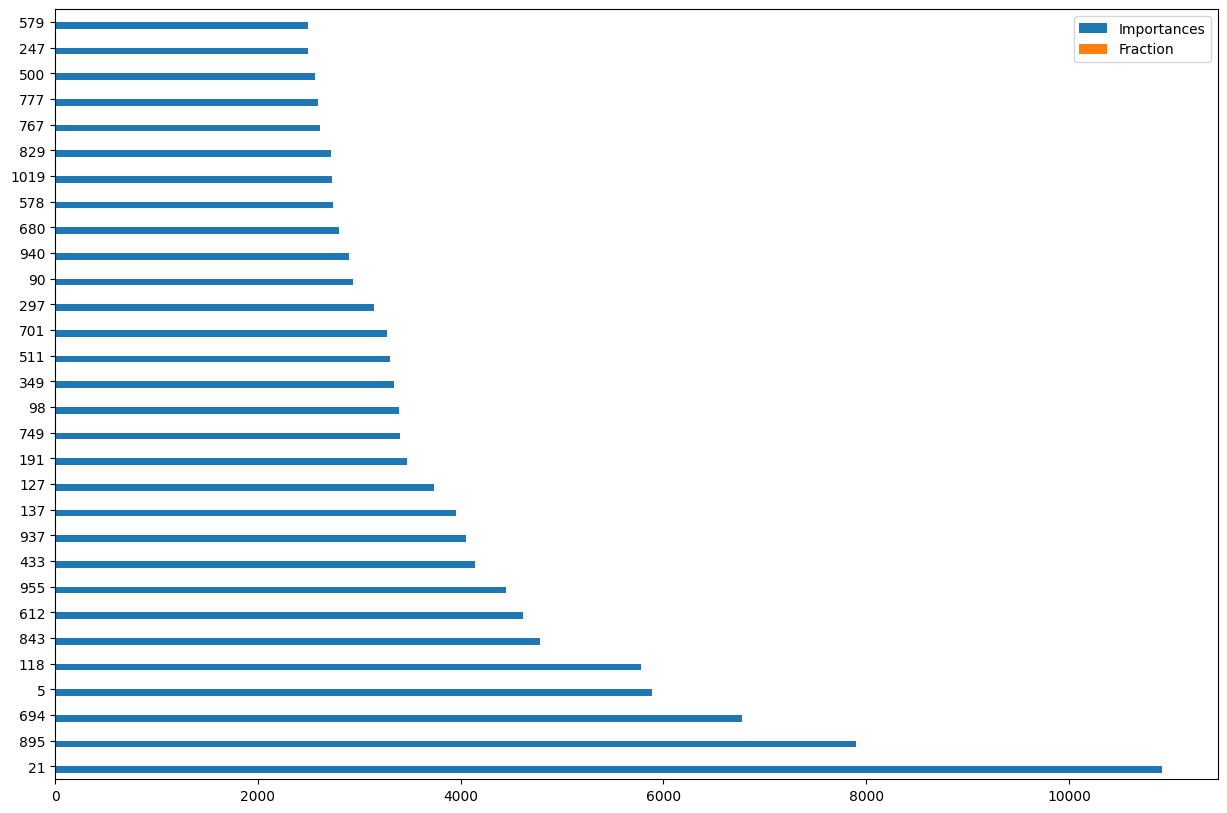

In [ ]:
impTable.loc[:,['Importances','Fraction']].nlargest(30, columns="Fraction").plot(kind='barh', figsize = (15,10)) ## plot top 40 features

In [ ]:
isel = np.argsort(-values)
val=values[isel]
for k in range(1024):
 rk = (np.sum(val[:k])/np.sum(val))
 if rk > 0.95:
  print(k)
  break


In [ ]:
iselect = keys[isel[:k]]
iselect